# Tema 5: SWAP Test

En este notebook vamos a implementar el **SWAP Test**, un algoritmo cuántico fundamental que nos permite estimar la similitud entre dos estados cuánticos arbitrarios. El SWAP Test es especialmente útil porque nos proporciona una forma de medir el producto interno (o solapamiento) entre dos estados sin necesidad de realizar una tomografía completa del estado.

El algoritmo utiliza un qubit auxiliar (ancilla) y aplica operaciones SWAP controladas entre los qubits que codifican los dos estados que queremos comparar. Al medir el qubit ancilla al final del circuito, podemos extraer información sobre cuán similares son los dos estados cuánticos.

La probabilidad de medir el estado $|0\rangle$ en la ancilla está directamente relacionada con el producto interno entre los dos estados: $P(0) = \frac{1 + |\langle\psi|\phi\rangle|^2}{2}$, donde $|\psi\rangle$ y $|\phi\rangle$ son los dos estados que estamos comparando.

A continuación, vamos a implementar el siguiente circuito:

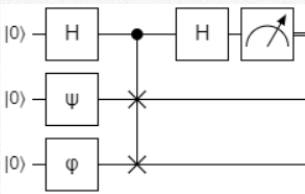

## Desarrollo teórico del SWAP Test

El SWAP Test es un algoritmo cuántico que permite estimar la similitud entre dos estados cuánticos $|\psi\rangle$ y $|\phi\rangle$ mediante el cálculo de su producto interno $|\langle\psi|\phi\rangle|^2$.

**Configuración inicial:**
- Un qubit auxiliar (ancilla) inicializado en $|0\rangle$
- $n$ qubits que codifican el estado $|\psi\rangle$
- $n$ qubits que codifican el estado $|\phi\rangle$

**Pasos del algoritmo:**

1. **Superposición de la ancilla:** Aplicamos una puerta Hadamard al qubit ancilla:
   $$H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$$

2. **SWAP controlado:** Aplicamos operaciones CSWAP (Fredkin gate) entre cada par de qubits correspondientes de los dos registros, controladas por la ancilla. Esta operación intercambia los estados $|\psi\rangle$ y $|\phi\rangle$ solo cuando la ancilla está en $|1\rangle$.

3. **Segunda Hadamard:** Aplicamos otra puerta Hadamard a la ancilla.

4. **Medición:** Medimos el qubit ancilla.

**Análisis matemático:**

Después de la primera Hadamard, el estado completo es:
$$\frac{1}{\sqrt{2}}(|0\rangle|\psi\rangle|\phi\rangle + |1\rangle|\psi\rangle|\phi\rangle)$$

Tras el CSWAP:
$$\frac{1}{\sqrt{2}}(|0\rangle|\psi\rangle|\phi\rangle + |1\rangle|\phi\rangle|\psi\rangle)$$

Después de la segunda Hadamard en la ancilla:
$$\frac{1}{2}[|0\rangle(|\psi\rangle|\phi\rangle + |\phi\rangle|\psi\rangle) + |1\rangle(|\psi\rangle|\phi\rangle - |\phi\rangle|\psi\rangle)]$$

**Probabilidad de medición:**

La probabilidad de medir $|0\rangle$ en la ancilla es:
$$P(0) = \frac{1}{2} + \frac{1}{2}|\langle\psi|\phi\rangle|^2$$

Por lo tanto, el producto interno al cuadrado se puede calcular como:
$$|\langle\psi|\phi\rangle|^2 = 2P(0) - 1$$

**Casos especiales:**
- Si $|\psi\rangle = |\phi\rangle$ (estados idénticos): $P(0) = 1$
- Si $|\psi\rangle \perp |\phi\rangle$ (estados ortogonales): $P(0) = 0.5$

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener 2n qubits objetivo y un qubit ancilla. Vamos a definirlo ya de forma abstracta con una función que reciba dos estados (y determine automáticamente el número de qubits).

In [2]:
def SWAP_Circuit(state1: np.array, state2: np.array):
    #Obtenemos el número de qubits como el logaritmo2 de la longitud del vector.
    n = int(np.ceil(np.log2(len(state1))))
    #Registros
    anc = QuantumRegister(1, 'ancilla')
    qr1 = QuantumRegister(n, 'q1')
    qr2 = QuantumRegister(n, 'q2')
    cr = ClassicalRegister(1, 'c')

    #Circuito
    qc = QuantumCircuit(anc, qr1, qr2, cr, name='SWAP')

    #H en la ancilla
    qc.h(anc[0])

    #Inicializamos los estados, también podemos usar StatePreparation
    qc.initialize(state1, qubits=qr1[:], normalize=True)
    qc.initialize(state2, qubits=qr2[:], normalize=True)
    qc.barrier()

    #Control-SWAP para cada pareja de qubits
    qc.cswap(anc[:]*n, qr1[:], qr2[:])
    qc.barrier()

    #H en ancilla
    qc.h(anc[0])
    qc.barrier()

    #Mediciones
    qc.measure(anc[0],0)

    #Esto es por visualización
    decomp_qc = qc.decompose(['State_Preparation'], reps=1)

    return decomp_qc

Ahora definamos dos estados para hacer la operación. Empezamos por dos iguales, para obtener 1.

In [3]:
#Vectores de estado
state1 = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state1 /= np.sqrt(sum(state1*np.conjugate(state1)))

state2 = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state2 /= np.sqrt(sum(state2*np.conjugate(state2)))

Creamos el circuito cuántico.

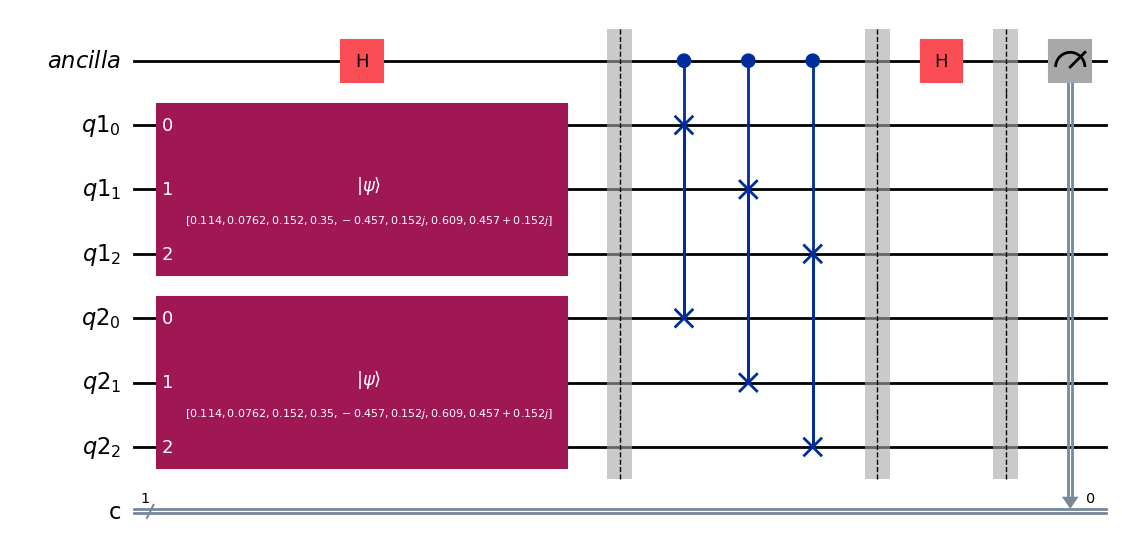

In [4]:
qc = SWAP_Circuit(state1, state2)

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

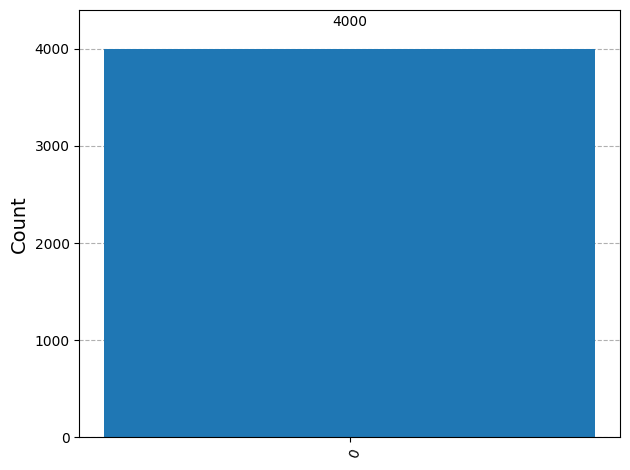

In [5]:
#Número de shots
n_shots = 4000

#Simulador
backend = AerSimulator()

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vamos a calcular el producto escalar como

$$|\langle \psi|\phi \rangle|^2 = 2P(0)-1$$


In [6]:
proy = 2* ( counts['0']/n_shots) - 1
proy

1.0

Vemos que efectivamente obtenemos 1.

---
# Probamos con otros estados

Ahora haz un circuito para otros estados y mira qué sucede con la precisión con el número de shots.

In [7]:
#Vectores de estado
state1 = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state1 /= np.sqrt(sum(state1*np.conjugate(state1)))

state2 = np.array([0.6+0.1j, -0.9+3j, 1.2, 0.2, -1, 0.3+1j, -2+2j, 3-1j])
state2 /= np.sqrt(sum(state2*np.conjugate(state2)))

#Creamos el circuito
qc = SWAP_Circuit(state1, state2)

#Número de shots
n_shots = 4000

#Simulador
backend = AerSimulator()

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

#Obtenemos la proyección a partir de las cuentas
proy = 2* ( counts['0']/n_shots) - 1


print('Cuántico: ', proy)
print('Exacto:   ', abs(np.conjugate(state1) @ state2)**2)

Cuántico:  -0.0014999999999999458
Exacto:    0.03124668490738293


In [8]:
#Vectores de estado
state1 = np.array([0.75, 0.5])
state1 /= np.sqrt(sum(state1*np.conjugate(state1)))

state2 = np.array([-0.6+0.1j, -0.9-3j])
state2 /= np.sqrt(sum(state2*np.conjugate(state2)))

#Creamos el circuito
qc = SWAP_Circuit(state1, state2)

#Número de shots
n_shots = 4000

#Simulador
backend = AerSimulator()

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

#Obtenemos la proyección a partir de las cuentas
proy = 2* ( counts['0']/n_shots) - 1


print('Cuántico: ', proy)
print('Exacto:   ', abs(np.conjugate(state1) @ state2)**2)

Cuántico:  0.33499999999999996
Exacto:    0.34343358017228354


In [9]:
#Vectores de estado
state1 = np.array([0.75, 0.5, 1, 2.3, -3, 1j, 4, 3+1j])
state1 /= np.sqrt(sum(state1*np.conjugate(state1)))

state2 = np.array([0.75, -0.5, 1, -2.3, -3, 1j, -4, 3+1j])
state2 /= np.sqrt(sum(state2*np.conjugate(state2)))

#Creamos el circuito
qc = SWAP_Circuit(state1, state2)

#Número de shots
n_shots = 8000

#Simulador
backend = AerSimulator()

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()

#Obtenemos la proyección a partir de las cuentas
proy = 2* ( counts['0']/n_shots) - 1


print('Cuántico: ', proy)
print('Exacto:   ', abs(np.conjugate(state1) @ state2)**2)

Cuántico:  -0.004750000000000032
Exacto:    2.72495989691703e-07


A mayor número de shots, mayor precisión obtenemos.